# Physics-Informed Neural Networks for Solving PDEs

### Model Definition with Physics Integration: 
The PINN model is constructed to take two inputs—spatial coordinates x and time coordinates t—and predicts an output u(x, t), which represents the solution to the PDE at a given spatial and temporal point. By using an architecture of fully connected layers with Tanh activations, the model learns to approximate the behavior of the physical system described by the PDE.

### Custom Loss Function (Physics-Informed): 
A custom loss function calculates the discrepancy between the predicted solution and the governing physical equation. Here, u(x, t) is computed in a way that respects the PDE by considering partial derivatives with respect to x and t. This allows the model to directly penalize predictions that do not align with the underlying physics.

### Training Loop with Validation: 
The model is trained using the Adam optimizer on synthetic spatial and temporal data. Throughout training, the model’s predictions are adjusted to minimize the physics-informed loss function. Both training and validation losses are tracked over the specified number of epochs, providing feedback on the model’s convergence and accuracy.

### Testing and Evaluation: 
After training, the model is tested on unseen data, allowing us to evaluate its ability to generalize to new spatial and temporal points.

### Visualization: 
The code includes visualizations to provide insights into:

• The model’s training and validation loss trends over time.

• The predicted solution values of u(x, t) on test data.

• Combined view of training/validation losses and test predictions, giving a holistic picture of the model's performance.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [3]:
class PINN(nn.Module):
    """
    A neural network model for solving partial differential equations (PDEs) using the Physics-Informed Neural Network (PINN) method.

    Attributes:
        hidden (nn.Sequential): A sequence of layers that defines the neural network architecture.
    """
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        """
        Forward pass of the neural network.

        Args:
            x (torch.Tensor): Input tensor representing the spatial coordinate.
            t (torch.Tensor): Input tensor representing the time coordinate.

        Returns:
            torch.Tensor: Output tensor representing the predicted solution.
        """
        inputs = torch.cat((x, t), dim=1)
        u = self.hidden(inputs)
        return u

In [4]:
def loss_fn(u_pred, x, t):
    """
    Loss function with a PDE residual.

    Args:
        u_pred (torch.Tensor): Predicted solution tensor.
        x (torch.Tensor): Input tensor representing the spatial coordinate.
        t (torch.Tensor): Input tensor representing the time coordinate.

    Returns:
        torch.Tensor: Loss tensor representing the mean squared residual.
    """
    u_x = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]  # Extracts gradient tensor
    u_t = torch.autograd.grad(u_pred, t, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]  # Extracts gradient tensor
    residual = u_t + u_pred * u_x
    return torch.mean(residual**2)

In [5]:
def train_model(model, optimizer, x_train, t_train, x_val, t_val, epochs=1000):
    """
    Train the model using the Adam optimizer.

    Args:
        model (PINN): Instance of the PINN model.
        optimizer (optim.Adam): Adam optimizer instance.
        x_train (torch.Tensor): Training data for the spatial coordinate.
        t_train (torch.Tensor): Training data for the time coordinate.
        x_val (torch.Tensor): Validation data for the spatial coordinate.
        t_val (torch.Tensor): Validation data for the time coordinate.
        epochs (int, optional): Number of training epochs. Defaults to 1000.

    Returns:
        list: List of training losses.
        list: List of validation losses.
    """
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        # Training step
        model.train()
        optimizer.zero_grad()
        u_pred_train = model(x_train, t_train)
        train_loss = loss_fn(u_pred_train, x_train, t_train)
        train_loss.backward()
        optimizer.step()

        # Validation step
        model.eval()
        u_pred_val = model(x_val, t_val)
        val_loss = loss_fn(u_pred_val, x_val, t_val)

        # Track losses
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        # Print loss every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss.item()}, Val Loss: {val_loss.item()}")

    return train_losses, val_losses

In [6]:
def test_model(model, x_test, t_test):
    """
    Test the model on unseen data.

    Args:
        model (PINN): Instance of the PINN model.
        x_test (torch.Tensor): Test data for the spatial coordinate.
        t_test (torch.Tensor): Test data for the time coordinate.

    Returns:
        torch.Tensor: Predicted solution tensor.
    """
    model.eval()
    with torch.no_grad():
        u_pred_test = model(x_test, t_test)
    return u_pred_test

In [7]:
def plot_results(train_losses, val_losses, u_pred_test, t_test):
    """
    Plot the training and validation losses, as well as the predicted solution.

    Args:
        train_losses (list): List of training losses.
        val_losses (list): List of validation losses.
        u_pred_test (torch.Tensor): Predicted solution tensor.
        t_test (torch.Tensor): Test data for the time coordinate.
    """
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot predicted solution
    plt.figure(figsize=(10, 5))
    plt.scatter(t_test.detach().numpy(), u_pred_test.detach().numpy(), color='blue', label='Predicted u(x, t)')
    plt.xlabel('t')
    plt.ylabel('Predicted u(x, t)')
    plt.title('Model Predictions on Test Data')
    plt.legend()
    plt.show()

    # Plot train and validation losses along with test predictions
    plt.figure(figsize=(15, 5))

    # Subplot for train and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Subplot for predicted vs actual values
    plt.subplot(1, 2, 2)
    plt.scatter(t_test.detach().numpy(), u_pred_test.detach().numpy(), color='blue', label='Predicted u(x, t)')
    plt.xlabel('t')
    plt.ylabel('Predicted u(x, t)')
    plt.title('Model Predictions on Test Data')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
# Generate synthetic data for training, validation, and testing
x_train = torch.rand(100, 1, requires_grad=True)
t_train = torch.rand(100, 1, requires_grad=True)
x_val = torch.rand(20, 1, requires_grad=True)
t_val = torch.rand(20, 1, requires_grad=True)
x_test = torch.rand(20, 1, requires_grad=True)
t_test = torch.rand(20, 1, requires_grad=True)

In [9]:
# Initialize the model and optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [10]:
# Train the model
train_losses, val_losses = train_model(model, optimizer, x_train, t_train, x_val, t_val)

Epoch 0, Train Loss: 0.012757677584886551, Val Loss: 0.0016288947081193328
Epoch 100, Train Loss: 1.1070695109083317e-05, Val Loss: 2.178875911340583e-05
Epoch 200, Train Loss: 6.331867552944459e-06, Val Loss: 1.0241176823910791e-05
Epoch 300, Train Loss: 3.7443228393385652e-06, Val Loss: 4.750715561385732e-06
Epoch 400, Train Loss: 2.5359645405842457e-06, Val Loss: 2.5518784241285175e-06
Epoch 500, Train Loss: 1.917278495966457e-06, Val Loss: 1.7544834918226115e-06
Epoch 600, Train Loss: 1.5071597090354771e-06, Val Loss: 1.3996052530274028e-06
Epoch 700, Train Loss: 1.18878926969046e-06, Val Loss: 1.17397405574593e-06
Epoch 800, Train Loss: 9.326629992756352e-07, Val Loss: 1.0007540822698502e-06
Epoch 900, Train Loss: 7.272723223650246e-07, Val Loss: 8.603357741776563e-07


In [11]:
# Test the model
u_pred_test = test_model(model, x_test, t_test)

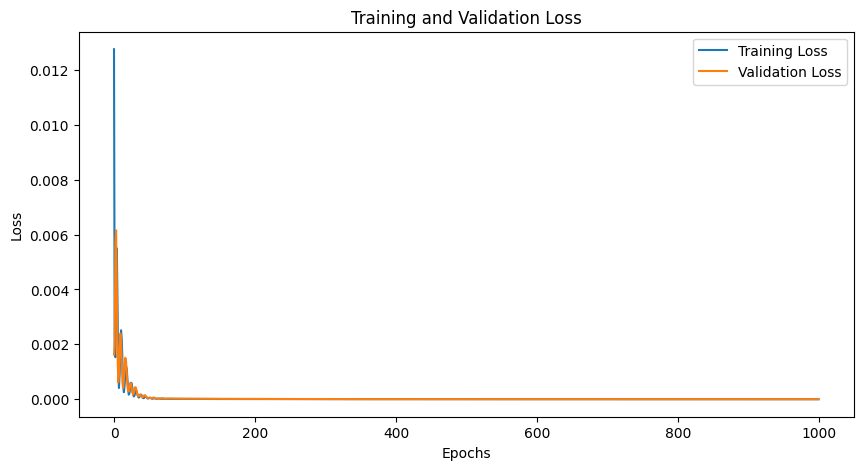

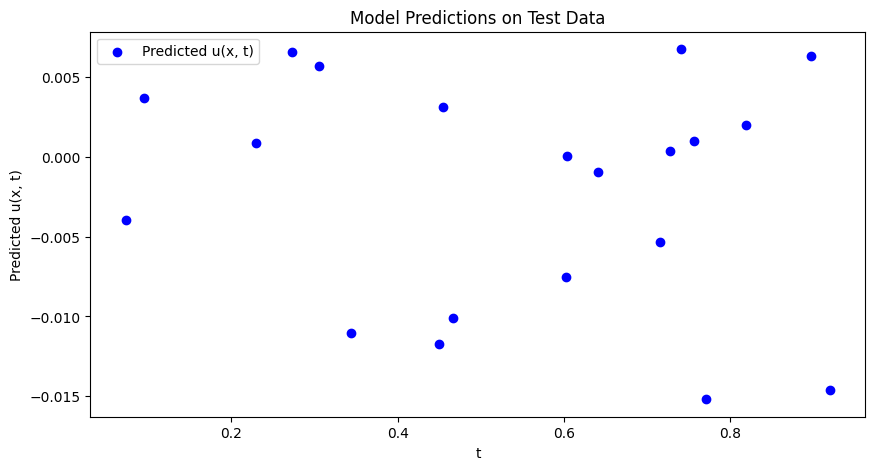

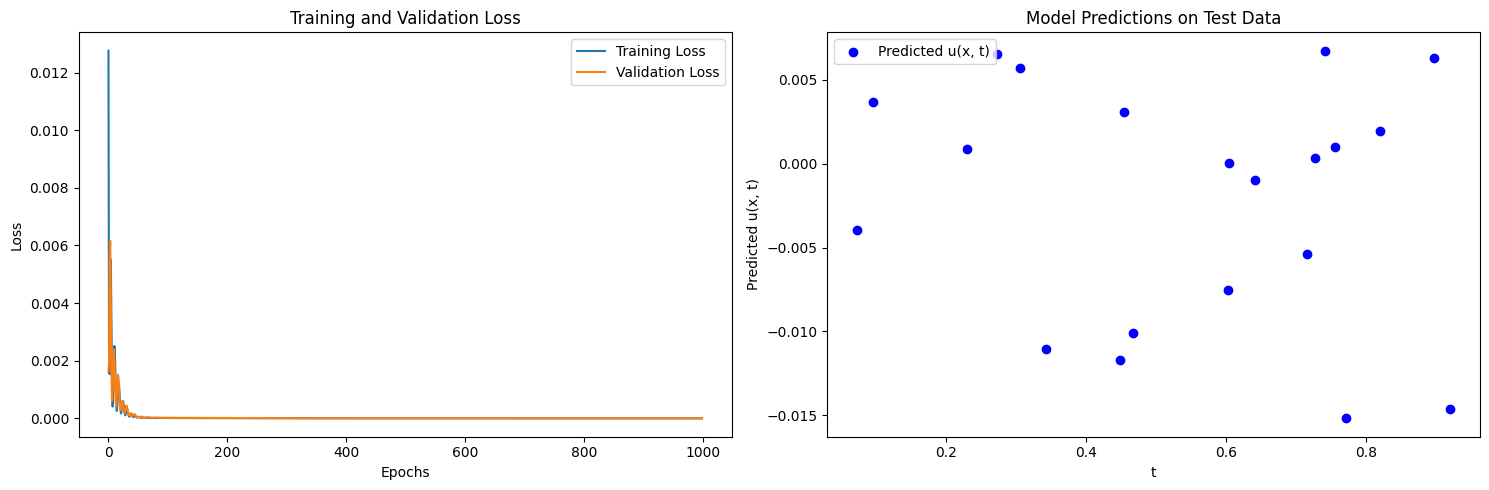

In [12]:
# Plot the results
plot_results(train_losses, val_losses, u_pred_test, t_test)

In [13]:
# Calculate and print the Mean Squared Error for test data
mse_test = mean_squared_error(u_pred_test.detach().numpy(), t_test.detach().numpy())
print(f"Mean Squared Error on Test Data: {mse_test}")


Mean Squared Error on Test Data: 0.3626576066017151
